In [1]:
!curl --version

curl 8.16.0 (Windows) libcurl/8.16.0 Schannel zlib/1.3.1 WinIDN
Release-Date: 2025-09-10
Protocols: dict file ftp ftps gopher gophers http https imap imaps ipfs ipns ldap ldaps mqtt pop3 pop3s smb smbs smtp smtps telnet tftp ws wss
Features: alt-svc AsynchDNS HSTS HTTPS-proxy IDN IPv6 Kerberos Largefile libz NTLM SPNEGO SSL SSPI threadsafe Unicode UnixSockets


In [2]:
!curl -L -o images.npz https://github.com/DivyanshuTak/Ultrasoud_Unet_Segmentation/raw/refs/heads/main/images.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  6 9601k    6  608k    0     0   454k      0  0:00:21  0:00:01  0:00:20  454k
 25 9601k   25 2403k    0     0  1028k      0  0:00:09  0:00:02  0:00:07 1795k
 54 9601k   54 5189k    0     0  1552k      0  0:00:06  0:00:03  0:00:03 2283k
 96 9601k   96 9228k    0     0  2119k      0  0:00:04  0:00:04 --:--:-- 2859k
100 9601k  100 9601k    0     0  2161k      0  0:00:04  0:00:04 --:--:-- 2896k


In [4]:
import numpy as np

In [5]:
data = np.load("images.npz")

In [6]:
data

NpzFile 'images.npz' with keys: images, filenames

In [7]:
all_images = data['images']

In [8]:
all_images.shape

(208, 300, 300, 3)

In [11]:
 %matplotlib inline

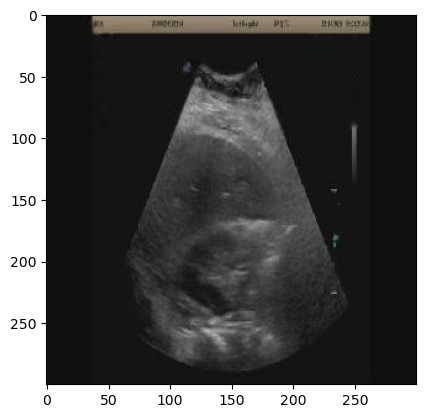

In [14]:
imshow(all_images[0])

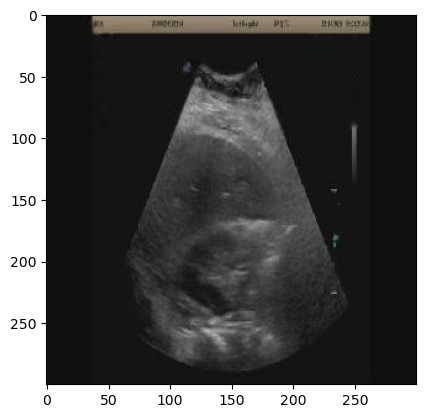

In [15]:
import matplotlib.pyplot as plt

plt.imshow(all_images[0])

In [17]:
!curl -L -o masks.npz https://github.com/DivyanshuTak/Ultrasoud_Unet_Segmentation/raw/refs/heads/main/masks.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 92714  100 92714    0     0   117k      0 --:--:-- --:--:-- --:--:--  117k


In [18]:
data2 = np.load("masks.npz")

In [19]:
data2

NpzFile 'masks.npz' with keys: masks, filenames

In [20]:
allmasks = data2["masks"]

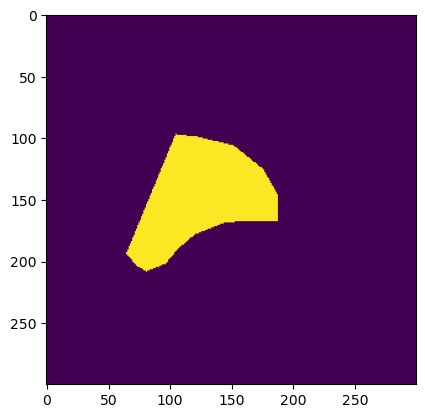

In [21]:
imshow(allmasks[0])

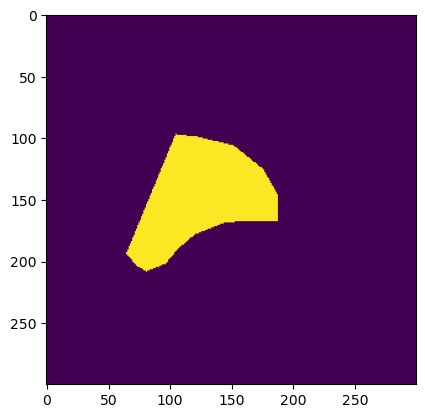

In [23]:
import matplotlib.pyplot as plt

plt.imshow(allmasks[0])

In [43]:
all_images = all_images[:, 24:]

In [44]:
allmasks = allmasks[:, 24:]

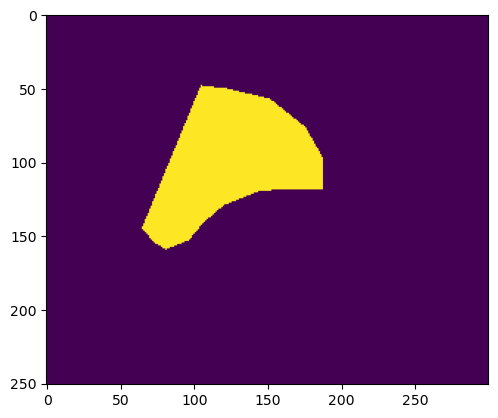

In [45]:
imshow(allmasks[0])

In [46]:
def show_overlay(index):
    plt.imshow(all_images[index], cmap='gray')
    plt.imshow(allmasks[index], cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.show()

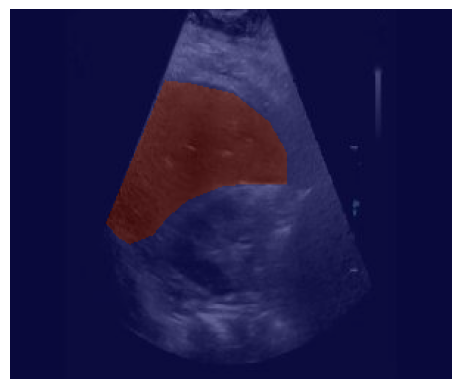

In [47]:
show_overlay(1)

In [48]:
def show_10_overlays():
    plt.figure(figsize=(15, 6))
    
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(all_images[i], cmap='gray')
        plt.imshow(allmasks[i], cmap='jet', alpha=0.4)
        plt.axis('off')
    
    plt.show()

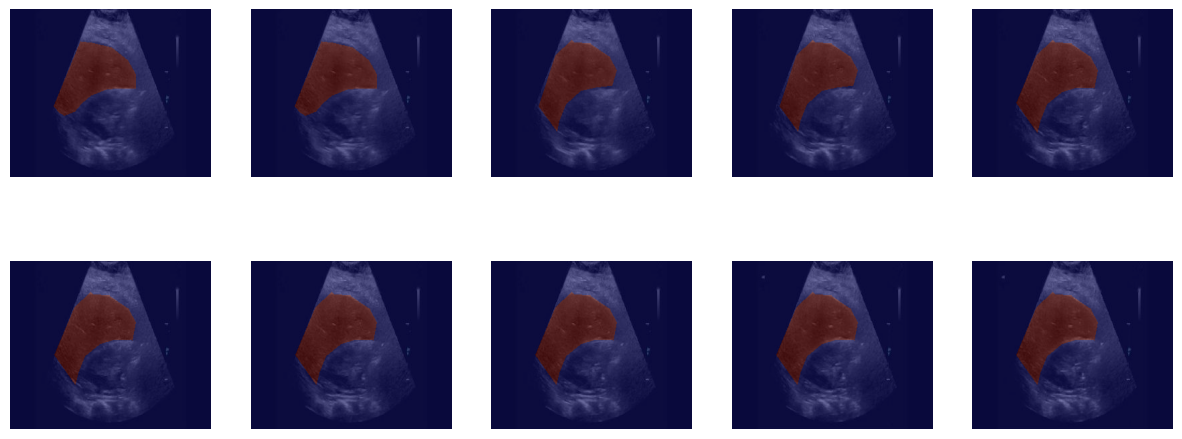

In [49]:
show_10_overlays()

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model

In [51]:
import numpy as np

X = all_images.astype("float32")
Y = allmasks.astype("float32")

# remove extra last dim if it exists (your case: ... ,1)
if X.ndim == 5: X = X.squeeze(-1)
if Y.ndim == 5: Y = Y.squeeze(-1)

# add channel ONLY if grayscale (N,H,W)
if X.ndim == 3: X = X[..., None]
if Y.ndim == 3: Y = Y[..., None]

# normalize + binarize
if X.max() > 1.0: X = X / 255.0
Y = (Y > 0).astype("float32")

print("X:", X.shape, "Y:", Y.shape)

X: (208, 251, 300, 3) Y: (208, 251, 300, 1)


In [52]:
# Shuffle
idx = np.random.permutation(len(X))
X, Y = X[idx], Y[idx]

# 80/20 split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = Y[:split], Y[split:]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (166, 251, 300, 3) (166, 251, 300, 1)
Val: (42, 251, 300, 3) (42, 251, 300, 1)


In [54]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def simple_unet(input_shape):
    inp = layers.Input(input_shape)

    # Down
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inp)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPool2D()(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPool2D()(c2)

    # Bottom
    b = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)

    # Up 2
    u2 = layers.UpSampling2D()(b)
    u2 = layers.Resizing(c2.shape[1], c2.shape[2])(u2)   # <-- FIX
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)

    # Up 1
    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Resizing(c1.shape[1], c1.shape[2])(u1)   # <-- FIX
    u1 = layers.Concatenate()([u1, c1])
    c4 = layers.Conv2D(16, 3, activation="relu", padding="same")(u1)

    out = layers.Conv2D(1, 1, activation="sigmoid")(c4)
    return Model(inp, out)

model = simple_unet(X_train.shape[1:])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 251, 300, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 251, 300, 16)      │             448 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 251, 300, 16)      │           2,320 │ conv2d_10[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 125, 150, 16)      │               0 │ conv2d_11[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 125, 150, 32)      │           4,640 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 125, 150, 32)      │           9,248 │ conv2d_12[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 62, 75, 32)        │               0 │ conv2d_13[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 62, 75, 64)        │          18,496 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_2               │ (None, 124, 150, 64)      │               0 │ conv2d_14[0][0]            │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resizing (Resizing)           │ (None, 125, 150, 64)      │               0 │ up_sampling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 125, 150, 96)      │               0 │ resizing[0][0],            │
│                               │                           │                 │ conv2d_13[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 125, 150, 32)      │          27,680 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_3               │ (None, 250, 300, 32)      │               0 │ conv2d_15[0][0]            │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resizing_1 (Resizing)         │ (None, 251, 300, 32)      │               0 │ up_sampling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 251, 300, 48)      │               

 Total params: 69,777 (272.57 KB)

 Trainable params: 69,777 (272.57 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=2
)

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.8924 - loss: 0.3230 - val_accuracy: 0.9074 - val_loss: 0.2009
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 407ms/step - accuracy: 0.9018 - loss: 0.2021 - val_accuracy: 0.9074 - val_loss: 0.1908
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 389ms/step - accuracy: 0.9018 - loss: 0.1876 - val_accuracy: 0.9074 - val_loss: 0.1714
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 392ms/step - accuracy: 0.9162 - loss: 0.1718 - val_accuracy: 0.9266 - val_loss: 0.1710
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 392ms/step - accuracy: 0.9279 - loss: 0.1604 - val_accuracy: 0.9315 - val_loss: 0.1542


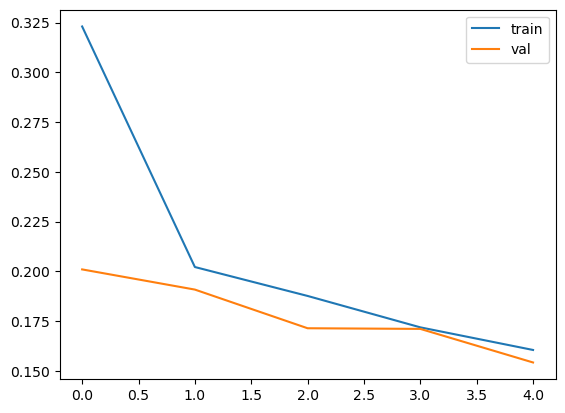

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


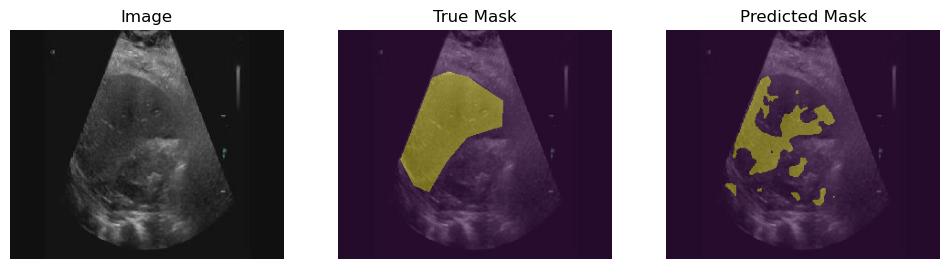

In [57]:
# Pick one validation image
i = 0

# Predict mask
pred = model.predict(X_val[i:i+1])[0]   # shape (300,300,1)

# Show image + ground truth + prediction
plt.figure(figsize=(12,4))

# Original Image
plt.subplot(1,3,1)
plt.imshow(X_val[i])
plt.title("Image")
plt.axis("off")

# Ground Truth Mask
plt.subplot(1,3,2)
plt.imshow(X_val[i])
plt.imshow(y_val[i].squeeze(), alpha=0.4)
plt.title("True Mask")
plt.axis("off")

# Predicted Mask
plt.subplot(1,3,3)
plt.imshow(X_val[i])
plt.imshow((pred.squeeze() > 0.5), alpha=0.4)
plt.title("Predicted Mask")
plt.axis("off")

plt.show()